In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt
import numpyro.distributions as dist

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80
tmp_max = 100.
tmp_min = 2.

In [2]:
cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Peak_sigmoid/cdf_files/CBC_z_0_4.cdf"
# "./RUNS/CBC_O3_peak.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [3]:
def massModel_variation_all_m1(m1, alpha_ref, mu_m1, delta_mu, width_mu, middle_mu, 
                               sig_m1, high_sig, width_sig, middle_sig, 
                               log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak, mMax, mMin, dmMax, dmMin, zs):
    
    p_m1_pl = (1.+alpha_ref)*m1**(alpha_ref)/(tmp_max**(1.+alpha_ref) - tmp_min**(1.+alpha_ref))

    new_mu_m1 = sigmoid(mu_m1, delta_mu, width_mu, middle_mu, zs)
    new_sig_m1 = sigmoid_no_delta(sig_m1, high_sig, width_sig, middle_sig, zs)

    p_m1_peak = jnp.exp(-(m1-new_mu_m1)**2/(2.*new_sig_m1**2))/jnp.sqrt(2.*np.pi*new_sig_m1**2)

    # Compute low- and high-mass filters
    low_filter = jnp.exp(-(m1-mMin)**2/(2.*dmMin**2))
    low_filter = jnp.where(m1<mMin,low_filter,1.)
    high_filter = jnp.exp(-(m1-mMax)**2/(2.*dmMax**2))
    high_filter = jnp.where(m1>mMax,high_filter,1.)

    new_f_peak = sigmoid_no_delta(log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak, zs) 
    actual_f_peak = 10.**(new_f_peak)
    combined_p = jnp.array((actual_f_peak*p_m1_peak + (1. - actual_f_peak)*p_m1_pl)*low_filter*high_filter)
    return combined_p

def sigmoid(low, delta, width, middle, zs):
    return delta / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

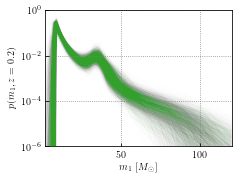

In [4]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(8.5*cm, 6.375*cm))
m_grid = np.linspace(2,120,500)
ax.set_rasterization_zorder(2)

pm_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))

for i in range(samps.alpha_ref.size):
    p_m = massModel_variation_all_m1(m_grid,samps.alpha_ref.values[i],
                                     samps.mu_m1.values[i], samps.delta_mu.values[i], samps.width_mu.values[i], samps.middle_z_mu.values[i],
                                     samps.sig_m1.values[i],samps.high_sig.values[i], samps.width_sig.values[i], samps.middle_z_sig.values[i],
                                     samps.log_f_peak.values[i],samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                     samps.mMax.values[i], samps.mMin.values[i],
                        10.**samps.log_dmMax.values[i],10.**samps.log_dmMin.values[i], 0.2)
    p_m /= np.trapz(p_m,m_grid)
    pm_matrix[i, :] = p_m
    ax.plot(m_grid,p_m,color='#33a02c',lw=0.05,alpha=0.1, zorder = 1)
    
ax.set_yscale('log')
ax.set_xlim(2,120)
ax.set_ylim(1e-6,1)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$p(m_1, z = 0.2)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("p(m)_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

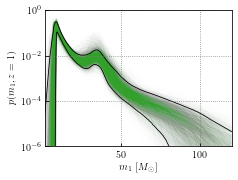

In [5]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(8.5*cm, 6.375*cm))
m_grid = np.linspace(2,120,500)
ax.set_rasterization_zorder(2)

for i in range(samps.alpha_ref.size):
    p_m = massModel_variation_all_m1(m_grid,samps.alpha_ref.values[i],
                                     samps.mu_m1.values[i], samps.delta_mu.values[i], samps.width_mu.values[i], samps.middle_z_mu.values[i],
                                     samps.sig_m1.values[i],samps.high_sig.values[i], samps.width_sig.values[i], samps.middle_z_sig.values[i],
                                     samps.log_f_peak.values[i],samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                     samps.mMax.values[i], samps.mMin.values[i],
                        10.**samps.log_dmMax.values[i],10.**samps.log_dmMin.values[i], 1)
    # p_m /= massModel_variation_all_m1(m_grid, samps.alpha_ref.values[i], samps.delta_alpha.values[i],
    #                                  samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
    #                                  samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
    #                                  samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
    #                                  samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
    #                                  samps.mMin.values[i], 10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i],
    #                                  samps.width_dm.values[i], samps.middle_z_dm.values[i], 10.**samps.log_dmMin.values[i], 0.2)
    p_m /= np.trapz(p_m,m_grid)
    ax.plot(m_grid,p_m,color='#33a02c',lw=0.05,alpha=0.1, zorder = 1)
    
ax.set_yscale('log')
ax.set_xlim(2,120)
ax.set_ylim(1e-6,1)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax.set_ylabel(r"$p(m_1, z = 1)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(m_grid,np.quantile(pm_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.8, alpha=1)
plt.plot(m_grid,np.quantile(pm_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.8, alpha=1)
plt.savefig("p(m, 1)_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

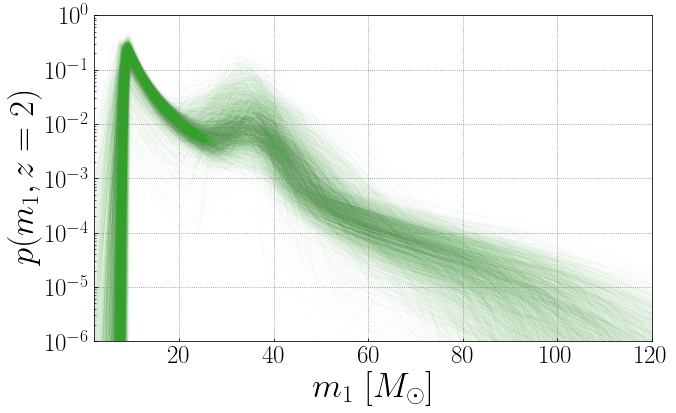

In [10]:
fig,ax = plt.subplots(figsize=(10,6))
m_grid = np.linspace(2,120,500)
ax.set_rasterization_zorder(2)

for i in range(samps.alpha_ref.size):
    p_m = massModel_variation_all_m1(m_grid,samps.alpha_ref.values[i],
                                     samps.mu_m1.values[i], samps.delta_mu.values[i], samps.width_mu.values[i], samps.middle_z_mu.values[i],
                                     samps.sig_m1.values[i],samps.high_sig.values[i], samps.width_sig.values[i], samps.middle_z_sig.values[i],
                                     samps.log_f_peak.values[i],samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                     samps.mMax.values[i], samps.mMin.values[i],
                        10.**samps.log_dmMax.values[i],10.**samps.log_dmMin.values[i], 2)
    # p_m /= massModel_variation_all_m1(m_grid, samps.alpha_ref.values[i], samps.delta_alpha.values[i],
    #                                  samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
    #                                  samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
    #                                  samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
    #                                  samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
    #                                  samps.mMin.values[i], 10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i],
    #                                  samps.width_dm.values[i], samps.middle_z_dm.values[i], 10.**samps.log_dmMin.values[i], 0.2)
    p_m /= np.trapz(p_m,m_grid)
    ax.plot(m_grid,p_m,color='#33a02c',lw=0.1,alpha=0.1, zorder = 0)
    
ax.set_yscale('log')
ax.set_xlim(2,120)
ax.set_ylim(1e-6,1)
ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 35)
ax.set_ylabel(r"$p(m_1,z = 2)$", fontsize = 35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig("p(m, 2)_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()